# INCAR 参数收敛性测试

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil

In [2]:
root_path = "./example/INCAR参数收敛性测试"
para_list = [200, 250, 300, 350, 400, 450, 500, 550, 600]

## 前处理

参数选取的问题是阻拦初学者入门理论模拟计算的最大难题。INCAR 参数的收敛性测试能帮助我们在保证计算精度的同时还可以大幅度节约计算资源。一般需要测试的参数为 ENCUT 和 KSPACING。下面以GeTe为例说明如何自动测试 ENCUT 参数。测试用的 POSCAR 和 POTCAR 文件放在 `./example/INCAR参数收敛性测试` 路径下。使用下面的代码创建作业文件夹，并使用 `qsub batchrunvasp.pbs` 提交作业。

In [ ]:
def link_or_copy(filename, root_path):
    """
    尝试在子目录中为文件创建硬链接，如果失败则复制文件。
    """
    subdirs = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
    src = os.path.join(root_path, filename)    
    for subdir in subdirs:
        dest = os.path.join(subdir, filename)
        try:
            os.link(src, dest)  # 尝试创建硬链接
        except OSError as e:
            shutil.copy(src, dest)  # 如果失败，复制文件

In [ ]:
os.makedirs(root_path, exist_ok=True)
for para in para_list:
    folder_path = os.path.join(root_path, str(para))
    os.makedirs(folder_path, exist_ok=True)
    lines = [
        "SYSTEM = GT",
        "NCORE = 8",
        "ISTART = 0",
        "ICHARG = 2",
        "LCHARG = .F.",
        "LWAVE = .F.",
        "KSPACING = 0.1",
        "KGAMMA = .T.",
        "ALGO = Fast",
        "NELM = 120",
        "NELMIN = 4",
        "EDIFF = 1E-07",
        "IBRION = -1",
        "NSW = 0",
        "EDIFFG = -1E-03",
        f"ENCUT = {para}",
        "ISMEAR = 0",
        "SIGMA = 0.05",
        "PREC = A",
        "LREAL = F",
        "ADDGRID = .T."
    ]
    with open(os.path.join(folder_path, 'INCAR'), 'w') as f:
        for line in lines:
            f.write(line + '\n')
            
link_or_copy("POSCAR", root_path)
link_or_copy("POTCAR", root_path)

pbs_script = """#PBS -N static
#PBS -l nodes=1:ppn=24
#PBS -l walltime=600:00:00
#PBS -q batch
#PBS -V
#PBS -S /bin/bash

source /opt/intel/compilers_and_libraries_2018/linux/bin/compilervars.sh intel64
source /opt/intel/mkl/bin/mklvars.sh intel64
source /opt/intel/impi/2018.1.163/bin64/mpivars.sh

NP=`cat $PBS_NODEFILE | wc -l`
NN=`cat $PBS_NODEFILE | sort | uniq | tee /tmp/nodes.$$ | wc -l`

cat $PBS_NODEFILE > /tmp/nodefile.$$
cd $PBS_O_WORKDIR
ulimit -s unlimited

# EXEC=/opt/software/vasp/vasp6.4.0/bin/vasp_gam
EXEC=/opt/software/vasp/vasp6.4.0/bin/vasp_std

for i in */
do
  if [ -e $i/vasprun.xml ]
  then
    echo 'skip ' $i >> ./tmp
  else
    cd $i
    mpirun -machinefile $PBS_NODEFILE -np $NP $EXEC > output
    time=`grep Elapsed OUTCAR`
    out=`tail -n 1 OUTCAR`
    echo $i >> ../tmp
    echo $time >> ../tmp
    echo $out >> ../tmp
    cd ..
  fi
done
"""
with open(os.path.join(root_path, 'batchrunvasp.pbs'), "w") as f:
    f.write(pbs_script)

计算完成后，使用 `check.sh` 查看计算任务是否均收敛。`check.sh` 脚本内容如下所示：

```shell
# Usage: ./check.sh
rm -rf ./tmp
ntot=0
nfinished=0
for i in */
do
    ((ntot++))
    echo '-------------------' >> ./tmp
    if [ -e "${i}OSZICAR" ]; then
        ((nfinished++))
        step=$(grep "=" "${i}OSZICAR" | tail -1)
        conv=$(grep ":" "${i}OSZICAR" | tail -1 | awk '{print $2,$4}')
        gprra=$(grep "required" "${i}OUTCAR")
        echo "$i" "$step" >> ./tmp
        echo "$i" "$conv" >> ./tmp
        echo "$i" "$gprra" >> ./tmp
    else
        echo "$i" '! ! !' >> ./tmp
    fi
done
echo "Total directories: $ntot"
echo "Unfinished directories: $((ntot - nfinished))"
```

当所有任务均收敛，即可进行数据后处理。

## 后处理

首先使用 python 提取不同任务输出的能量和计算时长。

In [3]:
def extract_elapsed_time(filepath):
    """提取 OUTCAR 中的计算时长 (Elapsed)。"""
    with open(filepath, 'r') as f:
        for line in f:
            if "Elapsed" in line:
                elapsed_time = line.strip().split()[-1]
                return float(elapsed_time)
    return None

def extract_total_energy(filepath):
    """提取 OSZICAR 中的总能 (最后一次迭代的能量)。"""
    with open(filepath, 'r') as f:
        lines = f.readlines()
    for line in reversed(lines):
        if ":" in line:
            return float(line.split()[2])  # 提取能量
    return None

def extract_num_atoms(filepath):
    """提取 POSCAR 中的原子总数 (第 7 行的所有元素和)。"""
    with open(filepath, 'r') as f:
        line = f.readlines()[6].strip()
    return sum(int(x) for x in line.split())

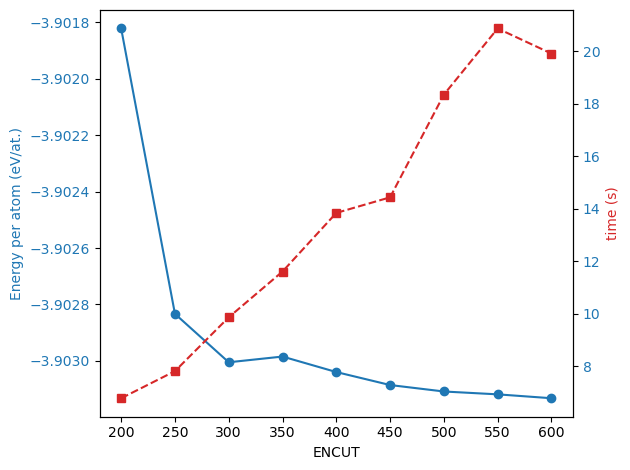

In [4]:
subdirs = [os.path.join(root_path, d) for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
time_list = []
energy_list = []
for subdir in subdirs:
    elapsed_time = extract_elapsed_time(os.path.join(subdir, "OUTCAR"))
    total_energy = extract_total_energy(os.path.join(subdir, "OSZICAR"))
    num_atoms = extract_num_atoms(os.path.join(subdir, "POSCAR"))
    time_list.append(elapsed_time)
    energy_list.append(total_energy / num_atoms)

x = np.array(para_list)
y1 = np.array(energy_list)
y2 = np.array(time_list)

fig, ax1 = plt.subplots()
color1 = 'tab:blue'
ax1.set_xlabel('ENCUT')
ax1.set_ylabel('Energy per atom (eV/at.)', color=color1)
line1 = ax1.plot(x, y1, color=color1, marker='o', label='energy')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('time (s)', color=color2)
line2 = ax2.plot(x, y2, color=color2, marker='s', linestyle='--', label='time')
ax2.tick_params(axis='y', labelcolor=color1)

# lines = line1 + line2
# labels = [l.get_label() for l in lines]
# ax1.legend(lines, labels, loc='best')

plt.tight_layout()
plt.savefig('./para_test.png', bbox_inches='tight')

一般当体系中每个原子的能量差收敛至 `0.001 eV/atom` 时，对应的 ENCUT 参数即为最终取值。写一个简单的 python 代码即可输出最终的 ENCUT 取值：

```python
for i in range(1, len(energy_list)):
    delta = energy_list[i] - energy_list[i-1]
    print(f"{para_list[i]}: {delta}")
    if np.abs(delta) < 0.001:
        break
```

结果显示，对于 GeTe 体系 ENCUT 取 300 eV 即可。

## 其它

ENCUT 测试通常从 ENMAX 开始测试，一般截止到 1.5*ENMAX 即可（注意：使用命令 `grep ENMAX POTCAR` 查看 ENMAX，ENCUT 小于 ENMAX 时可能会得到错误的能量）。

KSPACING 测试通常从 0.3（大致对应 VASPKIT 中的 0.05）开始测试，一般截止到 0.05（大致对应 VASPKIT 中的 0.01）即可。KSPACING 的单位是 $Å^{-1}$，VASPKIT 中的 KPT-Resolved Value 的单位是 $2π*Å^{-1}$。 

下面提一些注意事项：
1. 超胞与晶胞具有几乎相同的收敛趋势和原子平均能，然而在相同参数设置下扩胞后的计算耗时远远超过了扩胞前，所以参数收敛性测试用晶胞即可。晶胞测得的参数可直接应用在超胞上。
2. 随着 ENCUT 的增加，计算时间并没有像 KSPACING 增加那样呈指数上升，其上升趋势较为平缓。所以一般先测试 KSPACING，然后保持 KSPACING 不变，再测试 ENCUT。在测试 KSPACING 的时候，ENCUT 不妨取大一些。
3. 除了 ENCUT 和 KSPACING，一般还需要测试 ISMEAR、SIGMA 以及并行参数如 NCORE、KPAR 等。另外，选用不同泛函优化得到的晶格常数会不一样，所以泛函也需要测试。